# SquashFS Practice

This is a introductory document to the functionality of SquashFS. 

The first section contains the basic features of this read-only compressed filesystem (make an image, mount an image, etc.)
The second and third one contain different benchmarks according to the settings on the SquashFS compression

In [2]:
import os # in order to run shell commands

## 1. Basic functionality

### _How to make a SquashFS image?_

mksquashfs is the tool for creating new squashed file systems, and for appending new data to existing squashed file systems. 

__Usage:__  _mksquashfs /some/dir dir.sqsh_

### _How to mount a SquashFS file?_

After creating the SquashFS image, it can be mounted through the _mount_ command using a loopback device

__Usage:__ _mkdir /mnt/dir_ __&&__ _mount dir.sqsh /mnt/dir -t squashfs -o loop_

### _How to unpack a SquashFS file?_

mksquashfs is the tool for creating new squashed file systems, and for appending new data to existing squashed file systems. 

__Usage:__  _unsquashfs filesystem.sqsh_

## 2. Benchmarks on SquashFS 

In [3]:
file = "enwik8" # change file to use enwik8 or enwik9

### _Imports_

In [4]:
import pandas as pd 
import time
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 6) # for the size of matplotlib plots

### 2.1 Experimenting with block size

There are different block sizes supported by SquashFS. In this case I analyse the performance on 6 of them. 

Having a smaller block size should result in smaller compression ratios since normal compression algorithms use the initial parts of files (a past) to codify the rest (a future).

In [5]:
block_sizes = {
    "4K": 4096,
    "8K": 8192,
    "16K": 16384,
    "32K": 32768,
    "64K": 65536,
    "128K": 131072, 
}

In [6]:
def make_squashfs_image(file, block_size, block_size_name):        
    
    file_name = file.split(".")[0]
    squashed_file = f"{file_name}-{block_size_name}.sqsh"
    
    # Make squash image and calc time 
    start_time = time.time()
    os.system(f"mksquashfs {file} {squashed_file} -b {block_size}")
    compression_time = time.time() - start_time

    compressed_size = os.popen(f"du {squashed_file}").read().split("\t")[0] # du command shows estimate space in KB

    return int(compressed_size), compression_time


def make_squashfs_image_zstd(file, compression_level):        
    
    file_name = file.split(".")[0]
    squashed_file = f"{file_name}-zstd{compression_level}.sqsh"
    
    # Make squash image and calc time 
    start_time = time.time()
    os.system(f"mksquashfs {file} {squashed_file} -comp zstd -Xcompression-level {compression_level}")
    compression_time = time.time() - start_time

    compressed_size = os.popen(f"du {squashed_file}").read().split("\t")[0] 
    return int(compressed_size), compression_time



def unsquash_image(file, block_size_name):
    
    file_name = file.split(".")[0]
    squashed_file = f"{file_name}-{block_size_name}"

    start_time = time.time()
    os.system(f"unsquashfs -d {squashed_file} -no-xattrs {squashed_file}.sqsh")
    decompression_time = time.time() - start_time
    
    return decompression_time
    
    
def unsquash_image_zstd(file, compression_level):
    
    file_name = file.split(".")[0]
    squashed_file = f"{file_name}-zstd{compression_level}"

    start_time = time.time()
    os.system(f"unsquashfs -d {squashed_file} -no-xattrs {squashed_file}.sqsh")
    decompression_time = time.time() - start_time
    
    return decompression_time


def calc_compression_ratio(size_before, size_compressed):
    return round((int(size_before) / int(size_compressed)), 2)


def calc_speed(size, time):
    size_in_mb = size / 1024 
    return round((size_in_mb / time), 2)

For every block size, a new compressed file will be created using the _mksquashfs_ command.

In [7]:
df = pd.DataFrame(columns=["block_size", "compressed_size", "compression_ratio", "compression_speed"])

og_size = int(os.popen(f"du {file}").read().split("\t")[0])
for key, value in block_sizes.items():

    c_size, c_time  = make_squashfs_image(file, value, key)
    
    c_ratio = calc_compression_ratio(og_size, c_size)
    c_speed = calc_speed(og_size, c_time)
    
    df = df.append({"block_size": key, "compressed_size": c_size, "compression_ratio": c_ratio, "compression_speed": c_speed}, ignore_index=True)

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on enwik8-4K.sqsh, block size 4096.
[===========================================================|] 24415/24415 100%

Exportable Squashfs 4.0 filesystem, gzip compressed, data block size 4096
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 45237.38 Kbytes (44.18 Mbytes)
	46.28% of uncompressed filesystem size (97751.98 Kbytes)
Inode table size 43591 bytes (42.57 Kbytes)
	44.58% of uncompressed inode table size (97772 bytes)
Directory table size 26 bytes (0.03 Kbytes)
	92.86% of uncompressed directory table size (28 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Number of 

#### 2.1.1 Results on block sizes

Compression ratios were indeed better with bigger block sizes. For compression and decompression speeds it seems that big blocks result on a lower compression speed but that also comes with a faster decompression. For the enwik8 file (which size is 100MB) 8KB blocks seem to offer a good balance.

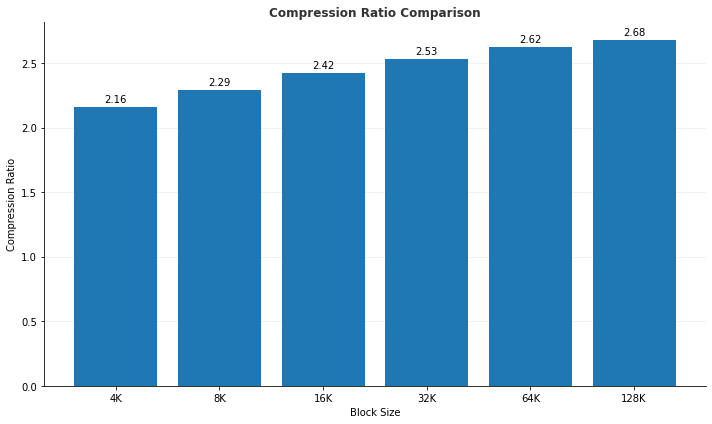

In [8]:
fig, ax = plt.subplots()

c_ratio_bars = ax.bar(x=df["block_size"], height=df["compression_ratio"])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')

ax.set_ylabel("Compression Ratio")
ax.set_xlabel("Block Size")
ax.bar_label(c_ratio_bars, padding=3)

ax.set_title('Compression Ratio Comparison', color='#333333', weight='bold')

fig.tight_layout()
plt.show()

In [9]:
dc_speeds = []
for i in range(len(df)):
    row = df.iloc[i]
    
    dc_time = unsquash_image(file, row["block_size"])
    dc_speed = calc_speed(row["compressed_size"], dc_time)

    dc_speeds.append(dc_speed)

df["decompression_speed"] = dc_speeds

Parallel unsquashfs: Using 16 processors
1 inodes (24415 blocks) to write

[===========================================================|] 24415/24415 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 devices
created 0 fifos
created 0 sockets
Parallel unsquashfs: Using 16 processors
1 inodes (12208 blocks) to write

[===========================================================|] 12208/12208 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 devices
created 0 fifos
created 0 sockets
Parallel unsquashfs: Using 16 processors
1 inodes (6104 blocks) to write

[=============================================================|] 6104/6104 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 devices
created 0 fifos
created 0 sockets
Parallel unsquashfs: Using 16 processors
1 inodes (3052 blocks) to write

[=============================================================|] 3052/3052 100%

created 1 file
created 1 directory
created 0 symlinks
create

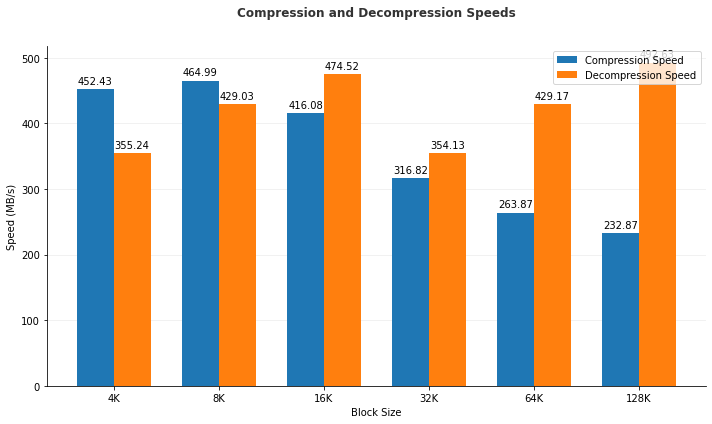

In [10]:
fig, ax = plt.subplots()

x = np.arange(len(df))
width = 0.35

c_speed_bars = ax.bar(x - width/2, df["compression_speed"], width, label="Compression Speed")
dc_speed_bars = ax.bar(x + width/2, df["decompression_speed"], width, label="Decompression Speed")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')

ax.set_ylabel("Speed (MB/s)")
ax.set_xlabel("Block Size")
ax.set_xticks(x)
ax.set_xticklabels(df["block_size"])
ax.legend()

ax.bar_label(c_speed_bars, padding=3)
ax.bar_label(dc_speed_bars, padding=3)

ax.set_title('Compression and Decompression Speeds', color='#333333', pad=30, weight='bold')

fig.tight_layout()
plt.show()

Run this cell to remove the created files 

In [11]:
os.system(f"ls | grep {file}- | xargs rm -R") 

0

### 2.2 Experimenting with SquashFS support for Zstandard

In [12]:
levels = list(range(1,23))

df_zstd = pd.DataFrame(columns=["compression_level", "compressed_size", "compression_ratio", "compression_speed"])

for level in levels:
    c_size, c_time  = make_squashfs_image_zstd(file, level)
    
    c_ratio = calc_compression_ratio(og_size, c_size)
    c_speed = calc_speed(og_size, c_time)
    
    df_zstd = df_zstd.append({"compression_level": int(level), "compressed_size": int(c_size), "compression_ratio": c_ratio, "compression_speed": c_speed}, ignore_index=True)

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on enwik8-zstd1.sqsh, block size 131072.
[===============================================================|] 763/763 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 131072
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 40424.03 Kbytes (39.48 Mbytes)
	41.39% of uncompressed filesystem size (97659.57 Kbytes)
Inode table size 1893 bytes (1.85 Kbytes)
	60.25% of uncompressed inode table size (3142 bytes)
Directory table size 28 bytes (0.03 Kbytes)
	100.00% of uncompressed directory table size (28 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Numbe

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on enwik8-zstd9.sqsh, block size 131072.
[===============================================================/] 763/763 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 131072
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 35279.20 Kbytes (34.45 Mbytes)
	36.12% of uncompressed filesystem size (97659.57 Kbytes)
Inode table size 1878 bytes (1.83 Kbytes)
	59.77% of uncompressed inode table size (3142 bytes)
Directory table size 28 bytes (0.03 Kbytes)
	100.00% of uncompressed directory table size (28 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Numbe

Parallel mksquashfs: Using 16 processors
Creating 4.0 filesystem on enwik8-zstd17.sqsh, block size 131072.
[===============================================================\] 763/763 100%

Exportable Squashfs 4.0 filesystem, zstd compressed, data block size 131072
	compressed data, compressed metadata, compressed fragments,
	compressed xattrs, compressed ids
	duplicates are removed
Filesystem size 34026.83 Kbytes (33.23 Mbytes)
	34.84% of uncompressed filesystem size (97659.57 Kbytes)
Inode table size 1851 bytes (1.81 Kbytes)
	58.91% of uncompressed inode table size (3142 bytes)
Directory table size 28 bytes (0.03 Kbytes)
	100.00% of uncompressed directory table size (28 bytes)
Xattr table size 54 bytes (0.05 Kbytes)
	100.00% of uncompressed xattr table size (54 bytes)
Number of duplicate files found 0
Number of inodes 2
Number of files 1
Number of fragments 0
Number of symbolic links 0
Number of device nodes 0
Number of fifo nodes 0
Number of socket nodes 0
Number of directories 1
Numb

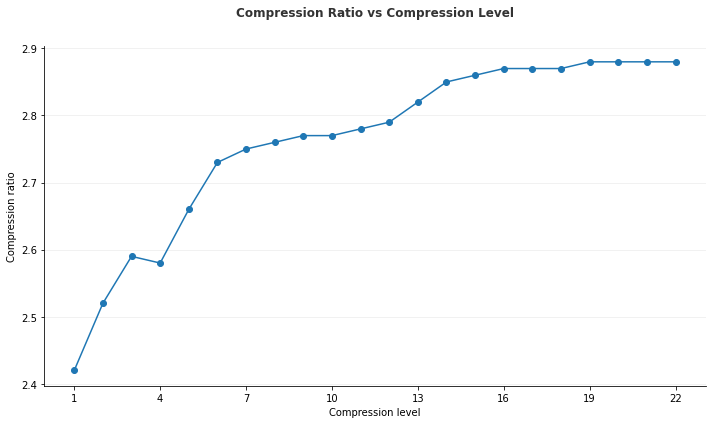

In [13]:
fig, ax = plt.subplots()

ax.plot(df_zstd["compression_level"], df_zstd["compression_ratio"], "o-")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.set_xticks(range(1, 23, 3))
ax.yaxis.grid(True, color='#EEEEEE')

ax.set_ylabel("Compression ratio")
ax.set_xlabel("Compression level")

ax.set_title('Compression Ratio vs Compression Level', color='#333333', pad=30, weight='bold')

fig.tight_layout()
plt.show()

In [14]:
dc_speeds_zstd = []
for i in range(len(df_zstd)):
    row = df_zstd.iloc[i]
    
    dc_time = unsquash_image_zstd(file, int(row["compression_level"]))
    dc_speed = calc_speed(row["compressed_size"], dc_time)

    dc_speeds_zstd.append(dc_speed)

df_zstd["decompression_speed"] = dc_speeds_zstd

Parallel unsquashfs: Using 16 processors
1 inodes (763 blocks) to write

[===============================================================|] 763/763 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 devices
created 0 fifos
created 0 sockets
Parallel unsquashfs: Using 16 processors
1 inodes (763 blocks) to write

[===============================================================|] 763/763 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 devices
created 0 fifos
created 0 sockets
Parallel unsquashfs: Using 16 processors
1 inodes (763 blocks) to write

[===============================================================|] 763/763 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 devices
created 0 fifos
created 0 sockets
Parallel unsquashfs: Using 16 processors
1 inodes (763 blocks) to write

[===============================================================|] 763/763 100%

created 1 file
created 1 directory
created 0 symlinks
created 0 de

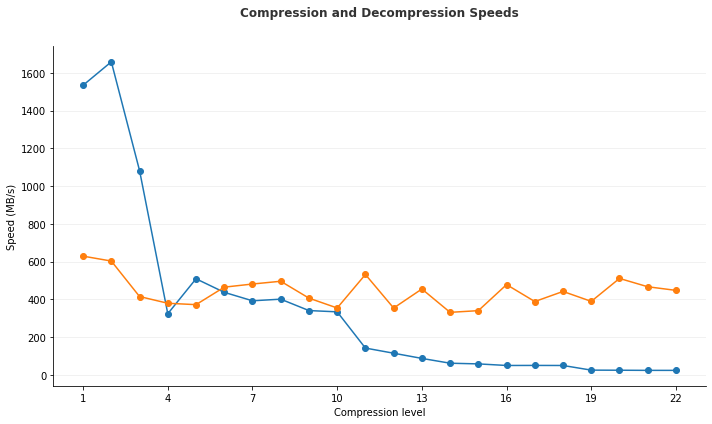

In [20]:
fig, ax = plt.subplots()

ax.plot(df_zstd["compression_level"], df_zstd["compression_speed"], "o-")
ax.plot(df_zstd["compression_level"], df_zstd["decompression_speed"], "o-")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axisbelow(True)
ax.set_xticks(range(1, 23, 3))
ax.yaxis.grid(True, color='#EEEEEE')

ax.set_ylabel("Speed (MB/s)")
ax.set_xlabel("Compression level")

ax.set_title('Compression and Decompression Speeds', color='#333333', pad=30, weight='bold')

fig.tight_layout()
plt.show()

In [21]:
os.system(f"ls | grep {file}-zstd | xargs rm -R") 

rm: missing operand
Try 'rm --help' for more information.


31488